In [1]:
import numpy as np
import random
from PIL import Image
import networkx as nx
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
%matplotlib widget

from cubic_spline_fit import CubicSpline2D, cubic_func
from extract_network import find_color, extract_network, render_skeleton, render_network

/home/ss/anaconda3/envs/extract_raster/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def image_to_graph(img: Image, simplify: bool=True) -> nx.Graph:
    rgb = (255, 255, 255)
    px = find_color(img, rgb).T
    return extract_network(px, min_distance=4, simplify=simplify)

def graph_to_polylines(g: nx.Graph, simplify: bool=True) -> list:
    polylines = []
    for (n1, n2, k) in g.edges(keys=True):
        edge = g[n1][n2][k]
        path = edge['path']
        if simplify:
            coords = np.array(path.coords)
        else:
            coords = np.array(path)
        polylines.append(coords)
    return polylines


img_id = 1
gray_file = f'samples/gt/{img_id}_gray.png'
color_file = f'samples/gt/{img_id}_scatter.png'
img_gray = Image.open(gray_file)
img_color = Image.open(color_file)

simplify = False
skel, graph = image_to_graph(img_gray, simplify=simplify)
polylines = graph_to_polylines(graph, simplify=simplify)

Skeleton px=6322
Adding 13/24 dense nodes to existing 307 nodes.
Extracted street network:
  - 152 nodes
  - 366 edges


Found 23 terminal nodes (nodes with only 1 degree connection)
Found 23 terminal nodes (nodes with only 1 degree connection)
at node (2, 60), node_angle = 32.7, color_angle = -149.5, angle_diff = 182.2, direction = 0
at node (2, 124), node_angle = 31.8, color_angle = 32.9, angle_diff = 1.1, direction = 1
at node (2, 176), node_angle = 31.8, color_angle = 32.7, angle_diff = 0.9, direction = 1
at node (3, 6), node_angle = 32.5, color_angle = -149.2, angle_diff = 181.7, direction = 0
at node (3, 33), node_angle = 31.7, color_angle = -149.2, angle_diff = 180.9, direction = 0
at node (3, 99), node_angle = 31.7, color_angle = 33.4, angle_diff = 1.7, direction = 1
at node (3, 152), node_angle = 31.7, color_angle = 32.7, angle_diff = 1.0, direction = 1
at node (287, 509), node_angle = -70.4, color_angle = 106.1, angle_diff = 176.5, direction = 0
at node (339, 509), node_angle = -68.8, color_angle = -73.7, angle_diff = 4.9, direction = 1
at node (363, 509), node_angle = -71.2, color_angle = -73.

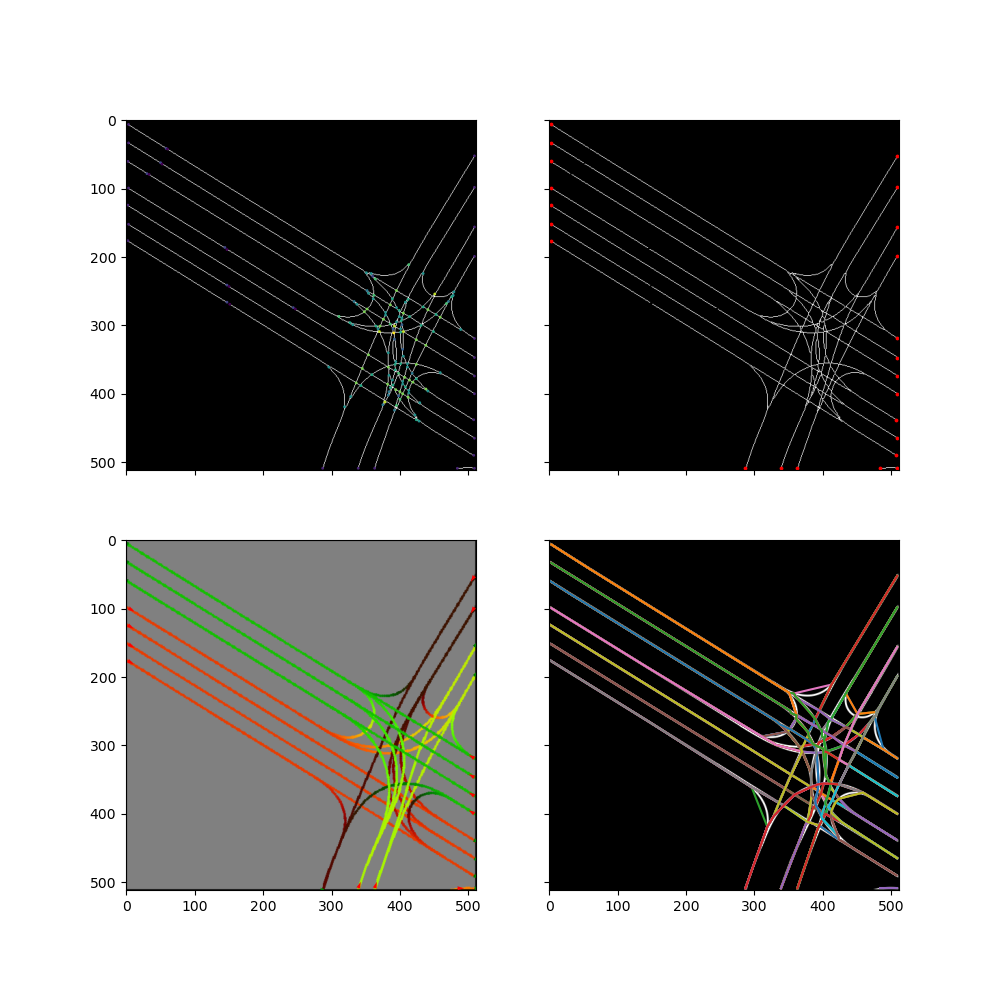

In [7]:
def connect_small_gaps(graph: nx.Graph, nodes: list[tuple], thresh: int=4) -> nx.Graph:
    for i, n1 in enumerate(nodes):
        for j, n2 in enumerate(nodes[i+1:]):
            dist = np.hypot(n1[0] - n2[0], n1[1] - n2[1])
            if dist <= thresh:
                n2, n2_neighbour, k = list(graph.edges(n2, keys=True))[0]
                e2 = graph[n2][n2_neighbour][k]
                e2_path = e2['path']
                e2_path.insert(0, n1)
                graph.remove_edge(n2, n2_neighbour)
                graph.add_edge(n1, n2_neighbour, path=e2_path, d=len(e2_path) - 1)
                break

    return graph


def find_terminal_nodes(graph: nx.Graph) -> list[tuple]:
    nodes_terminal = [(node[0], node[1]) for (node, degree) in graph.degree if degree == 1]
    print(f'Found {len(nodes_terminal)} terminal nodes (nodes with only 1 degree connection)')

    return nodes_terminal
    
def find_terminal_directions(graph: nx.Graph, nodes: list[tuple], img_color: Image) -> list[tuple]:
    
    def normalize_dx_dy(dx, dy) -> tuple:
        norm = np.hypot(dx, dy)
        dx = dx/norm
        dy = dy/norm
        
        return dx, dy
    
    directed_terminals = []
    for n1 in nodes:
        n1, n1_neighbour, k = list(graph.edges(n1, keys=True))[0]
        dx, dy = normalize_dx_dy(n1_neighbour[0] - n1[0], n1_neighbour[1] - n1[1])
        node_angle = np.rad2deg(np.arctan2(dy, dx))

        n1_color = img_color.getpixel(n1)
        color_dx, color_dy = normalize_dx_dy(n1_color[0] - 128, 128 - n1_color[1])
        color_angle = np.rad2deg(np.arctan2(color_dy, color_dx))

        direction = 1 # inlet
        angle_diff = np.fabs(color_angle - node_angle)
        if angle_diff > 90.0: # if direction difference is smaller than 90 degrees
            direction = 0 # outlet
            dx = -dx
            dy = -dy

        print(f'at node {n1}, node_angle = {node_angle:.1f}, color_angle = {color_angle:.1f}, angle_diff = {angle_diff:.1f}, direction = {direction}')
        directed_terminals.append((n1[0], n1[1], dx, dy, color_dx, color_dy, direction))

    return directed_terminals


# def generate_frenet_frame(centerline_pts: np.ndarray):
def generate_frenet_frame(xs: np.ndarray, ys: np.ndarray):
    cubic_spline = CubicSpline2D(xs, ys)
    s = np.arange(0, cubic_spline.s[-1], 1)
    ref_xy = [cubic_spline.calc_position(i_s) for i_s in s]
    ref_yaw = [cubic_spline.calc_yaw(i_s) for i_s in s]
    ref_rk = [cubic_spline.calc_curvature(i_s) for i_s in s]

    return cubic_spline, np.column_stack((ref_xy, ref_yaw, ref_rk))


def track_path(path: list) -> np.ndarray:
    return


def path_is_valid(path: list) -> bool:
    
    return True


def find_paths_among_terminals(graph: nx.Graph, inlets: np.ndarray, outlets: np.ndarray, thresh: int=4) -> list[list]:
    inlets_T = inlets.T.astype(int)
    outlets_T = outlets.T.astype(int)
    inlets = list(zip(inlets_T[0], inlets_T[1]))
    outlets = list(zip(outlets_T[0], outlets_T[1]))

    paths = []
    for n1 in inlets:
        for n2 in outlets:
            if nx.has_path(graph, source=n1, target=n2):
                path = nx.shortest_path(graph, n1, n2, weight='d', method='dijkstra')
                # print(f'From {n1} to {n2}: {path}')
                if path_is_valid(path):
                    paths.append(np.array(path))
    
    print(f'Found {len(paths)} paths')
    return paths


def connect_terminal_nodes(graph: nx.Graph) -> nx.Graph:

    fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
    axes = axes.ravel()

    nodes = np.array([node for (node, degree) in graph.degree()], dtype=float)
    degrees = np.array([degree for (node, degree) in graph.degree()], dtype=float)
    axes[0].imshow(skel.T, cmap='gray')
    axes[0].scatter(nodes[:, 0], nodes[:, 1], c=degrees, s=1)

    nodes_1_degree = find_terminal_nodes(graph)
    graph = connect_small_gaps(graph, nodes_1_degree, thresh=8)
    nodes_1_degree_np = np.array(nodes_1_degree)
    axes[1].imshow(skel.T, cmap='gray')
    axes[1].scatter(nodes_1_degree_np[:, 0], nodes_1_degree_np[:, 1], c='red', s=3)

    nodes_terminal = find_terminal_nodes(graph)
    nodes_directed = find_terminal_directions(graph, nodes_terminal, img_color)
    nodes_directed_np = np.array(nodes_directed)
    
    inlets = nodes_directed_np[nodes_directed_np[:, -1] > 0.5]
    outlets = nodes_directed_np[nodes_directed_np[:, -1] < 0.5]

    axes[2].imshow(img_color)
    axes[2].quiver(inlets[:, 0], inlets[:, 1], inlets[:, 2], inlets[:, 3], 
                   color='r', angles='xy', scale_units='xy', scale=0.1)
    axes[2].quiver(outlets[:, 0], outlets[:, 1], outlets[:, 2], outlets[:, 3], 
                   color='g', angles='xy', scale_units='xy', scale=0.1)
    # axes[2].quiver(nodes_directed_np[:, 0], nodes_directed_np[:, 1], nodes_directed_np[:, 4], nodes_directed_np[:, 5], 
    #                color='b', angles='xy', scale_units='xy', scale=0.1)
    paths = find_paths_among_terminals(graph, inlets, outlets)
    
    axes[3].imshow(img_gray)
    for i, path in enumerate(paths):
        xs = path[:, 0]
        ys = path[:, 1]
        axes[3].plot(xs, ys)

    axes[0].set_aspect('equal')
    axes[1].set_aspect('equal')
    axes[2].set_aspect('equal')
    axes[3].set_aspect('equal')

    plt.show()
    
    return graph

connect_terminal_nodes(graph)

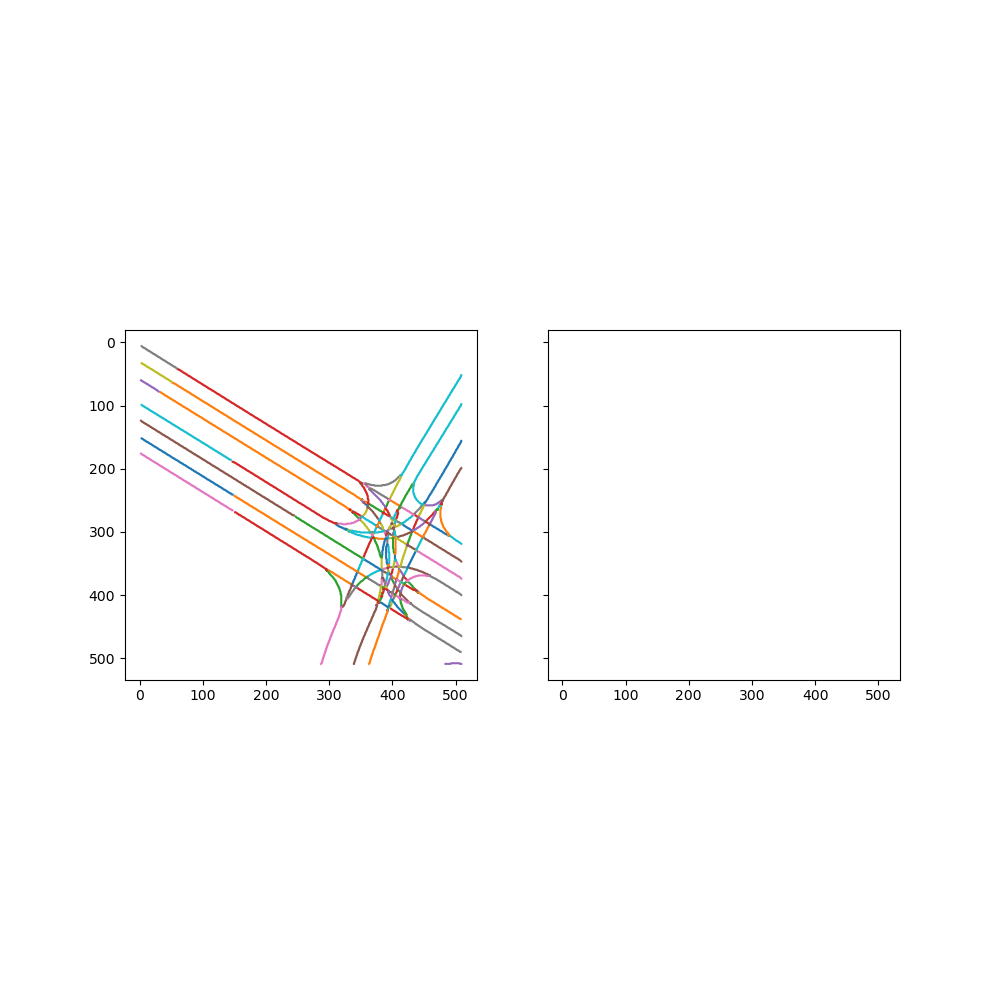

In [4]:
def plot_polylines(polylines: list) -> None:
    fig, axes = plt.subplots(1, 2, figsize=(10, 10), sharex=True, sharey=True)
    axes = axes.ravel()

    def random_color():
        return '#{:02X}{:02X}{:02X}'.format(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    
    def generate_random_colors(n):
        return [random_color() for _ in range(n)]

    color = generate_random_colors(len(polylines))

    for i, polyline in enumerate(polylines):
        xs = polyline[:, 0]
        ys = polyline[:, 1]
        axes[0].plot(xs, ys)

        # cubic_spline, ref_curve = generate_frenet_frame(xs, ys)
        # dy = np.sin(ref_curve[:, 2]) / 5
        # dx = np.cos(ref_curve[:, 2]) / 5
        # axes[1].quiver(ref_curve[:, 0], ref_curve[:, 1], dx, dy, color=color[i], angles='xy', scale_units='xy', scale=0.1)

    # img_skeleton = render_skeleton(img_gray, skel, (255, 0, 0))
    # img_network = render_network(img_gray, g, (0, 255, 0))
    # axes[0].imshow(img_skeleton)
    # axes[1].imshow(img_network)
    axes[0].set_aspect('equal')
    axes[0].invert_yaxis()
    axes[1].set_aspect('equal')
    plt.show()

    return

plot_polylines(polylines)